## OLS, MLE and simulating data

Here we are learning two things:

1. How to simulate a fake dataset in order to verify that our models we've coded up are correct. This works because if we know the true data generating process, as you will with the fake dataset, a correctly written model should be able to provide the correct coefficient estimates (that you chose!).
2. To see how effect sizes and sample sizes matter for hypothesis testing and precision in estimation.

In [1]:
# Pkg.add("Distributions")
# Pkg.add("NLopt")
# Pkg.add("PyPlot")
# Required packages, may need to uncomment the lines above and add these two packages before using them
using NLopt
using Distributions
using PyPlot

The next cell defines how many observations we have and then generates data based on the true beta coefficients of our model

In [2]:
# Number of observations of generated data
N = 1000

# Generate 100 mean 0 sd 1 random variables
X1 = randn(1000)
X2 = randn(1000)
X3 = randn(1000)

# Create covariate matrix
X = [ones(N) X1 X2 X3]

# True coefficients
true_betas = [.1, .05, -.003, 0.]

# Disturbance terms
epsilons = randn(1000)

# Outcome variable of our regression
Y = X*true_betas + epsilons

println("Data generated.")

Data generated.


Test the mean of the outcome variables, it should be close to the intercept term (0.1) since the X variables are mean 0.

In [3]:
inv(X'X)*X'Y

4-element Array{Float64,1}:
  0.0977994 
  0.0445669 
 -0.0119273 
 -0.00885767

Define the negative log likelihood to maximize. NLopt has weird behavior where the function you're maximizing can only take one argument, the control you are searching over, besides a gradient which is allowed to be empty. If you declare the other variables in loglike above the function (i.e. the data were declared in a cell above), then it will be in the function's scope and the function see it even though it doesn't directly get passed the variables through the normal function arguments. If this is confusing look up more on scope in Julia.

In [4]:
# Log likelihood function, rho is the vector coefficients we're searching over, grad is just an empty input in case we wanted to put in the gradient of the loglikelihood (we don't).
function loglike(rho::Array{Float64}, grad::Array{Float64})
    # Coefficients
    beta = rho[1:4]
    # Disturbance term std dev
    sigma2 = exp(rho[5])
    # Residual, normally distributed
    residual = Y - X*beta
    # Sum log likelihoods
    loglikelihood = sum(logpdf(Normal(0,sigma2), residual))
    return loglikelihood
end

loglike (generic function with 1 method)

In [5]:
# Initial guess
initial_rhos = [1., 1., 1., 1., 1.]

# Select optimizer, BOBYQA is a derivative-free optimizer that's pretty reliable
# In NLopt if you want to use Newton-style optimizers you will need to supply a gradient
opt = Opt(:LN_BOBYQA,5)

# Set tolerances
ftol_abs!(opt, 1e-8)
ftol_rel!(opt, 1e-8)
xtol_rel!(opt, 1e-10)
xtol_abs!(opt, 1e-10)
# Stop searching after 5000 tries
maxeval!(opt, 5000)

# Declare maximization problem
max_objective!(opt, loglike)

# Maximize the loglikelihood, return the values, coefficients, and an exitflag that gives us information on convergence
(loglikevalue,betas,ret) = optimize(opt, initial_rhos)

# Put sigma back in correct terms
betas[5] = exp(betas[5])

if ret == :FTOL_REACHED
    println("Converged to coefficients: $betas.")
else
    println("Exitflag: $(ret).")
end

Converged to coefficients: [0.102249,0.0659419,0.00487926,-0.0123776,0.984067].


How can we get standard errors for MLE? Bootstrapping. Bootstrap your standard errors.

In [6]:
# Function that samples data with replacement and then maximizes the loglikelihood
function bootstrap_mle(M::Int64,X::Array{Float64},Y::Array{Float64},initial_rhos::Array{Float64},opt)
    
    # Array indices of the values to sample
    sample_index = wsample(1:M,ones(M)/M,M)
    X_boot = X[sample_index,:]
    Y_boot = Y[sample_index]
    
    # Loglikelihood function for bootstrapping
    function loglike_boot(rho::Array{Float64}, grad::Array{Float64})
        # Coefficients
        beta = rho[1:4]
        # Disturbance term std dev
        sigma2 = exp(rho[5])
        # Residual, normally distributed
        residual = Y_boot - X_boot*beta
        # Sum log likelihoods
        loglikelihood = sum(logpdf(Normal(0,sigma2), residual))
        return loglikelihood
    end
    
    # Set tolerances
    ftol_abs!(opt, 1e-8)
    ftol_rel!(opt, 1e-8)
    xtol_rel!(opt, 1e-10)
    xtol_abs!(opt, 1e-10)
    # Stop searching after 5000 tries
    maxeval!(opt, 5000)

    # Declare maximization problem
    max_objective!(opt, loglike_boot)

    # Maximize the loglikelihood of the bootstrapped sample
    (loglikevalue,betas,ret) = optimize(opt, initial_rhos)
    
    # Put sigma back in correct terms
    betas[5]= exp(betas[5])
    
    return betas

end

bootstrap_mle (generic function with 1 method)

In [7]:
# Number of samples to bootstrap
num_samples = 1000

# Initialize bootstrap sample array
samples = Array{Float64}(num_samples,5)

# Start bootstrapping
for b = 1:num_samples
    samples[b,:] = bootstrap_mle(N,X,Y,initial_rhos,opt)
end

In [8]:
bootstrapSE = std(samples,1)
conf_radius = 1.96*bootstrapSE

1×5 Array{Float64,2}:
 0.060904  0.0577299  0.0604946  0.0588846  0.0443827

Now lets do some nonparametric hypothesis testing that our estimates are $\neq$ 0. With normally distributed variables we can also do the normal-specific hypothesis tests that you are used to.

In [9]:
# Calculate nonparametric p-values
null_dist = Array{Float64}(num_samples,5)

# Demean the bootstrapped samples
for i = 1:5
    null_dist[:,i] = samples[:,i] - mean(samples[:,i])
end

pvalues = Vector{Float64}(4)
for i = 1:4
    pvalues[i] = mean(abs(betas[i]).<abs(null_dist[:,i]))
end
println("Our pvalues are $pvalues.")

Our pvalues are [0.002,0.027,0.873,0.661].


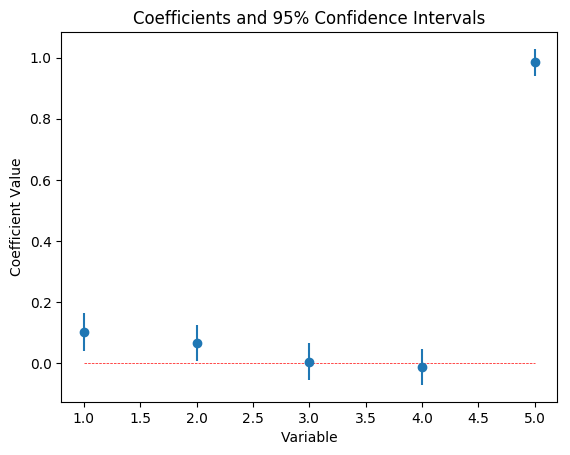

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcd5b86cd10>

In [10]:
# Plot the estimates and confidence intervals
errors = [conf_radius;conf_radius]
errorbar(1:5,betas,yerr=errors,fmt="o")
title("Coefficients and 95% Confidence Intervals")
xlabel("Variable")
ylabel("Coefficient Value")
plot(1.:.01:5., zeros(size(1.:.01:5.)), color="red", linewidth=0.5, linestyle="--")

Now adjust the magnitudes of the true $\beta$s or the number of observations. Re-run the code, and see how the p values change.